In [1]:
%matplotlib inline

In [2]:
import json
import gff3_parsing
import subprocess
from matplotlib import pyplot as plt
# import pandas as pd
import numpy as np
from scipy import stats
import glob

In [42]:
def analyze_secondary(dataframe, energy_dict, constraint, expected_len=50):
    for index in dataframe.index[:]:
#         upstream = dataframe.loc[index,"upstream_sequence"]
#         downstream = dataframe.loc[index,"coding_sequence"][:expected_len]
#         if len(upstream) != expected_len:
#             continue
#         if len(downstream) != expected_len:
#             continue
#         test_string = upstream.replace("T", "U")+downstream.replace("T", "U")
        cds = dataframe.loc[index, "coding_sequence"]
        mp = len(cds)//2
        test_string = cds[mp-50:mp+50]
        if len(test_string) != 100:
            continue
        test_string = test_string.replace('T', 'U')
        if test_string.count("A") + test_string.count("U") +\
                                    test_string.count("C") + test_string.count("G") != len(test_string):
            continue
        RNA_out = call_RNAfold(test_string)
        ensemble, mfe = get_energy_RNAfold(RNA_out)
        dataframe.at[index, "secondary_structure"] = ensemble
        
        ###Now call it in the constrained form such that the SD region is unpaired
        RNA_out = call_RNAfold(str(test_string)+'\n'+constraint)
        ensemble, mfe = get_energy_RNAfold(RNA_out)
        dataframe.at[index, 'secondary_structure_constrained'] = ensemble
    return dataframe

def call_RNAfold(sequence):
    MyOut = subprocess.Popen(['RNAfold', '-p', '--noPS', '--constraint'],
            stdin=subprocess.PIPE,
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT)
    stdout, stderr = MyOut.communicate(input=str.encode(sequence))
    return stdout

def get_energy_RNAfold(stdout_string):
    temp = stdout_string.decode("utf-8") 
    energy_line = temp.split('\n')[-5]
    energy_val = energy_line[energy_line.index(' '):]
    energy_val = energy_val.strip().strip('()').strip()
    
    mfe_line = temp.split('\n')[-4]
    mfe_val = mfe_line[energy_line.index(' '):]
    mfe_val = mfe_val.strip().strip('[]').strip()
    return float(energy_val), float(mfe_val)    




In [35]:
constraint = ('.'*37) + ('x'*25)+ ('.'*38)
print(len(constraint))

100


In [49]:
with open('../Data/energy_files/energyRef_CCUCCU_mfe_noneConstraint.json', 'r') as infile:
       energy_dict = json.load(infile)


host_df, host_genome = gff3_parsing.compile_sequences(["../Data/host_genomes/562.gff3"],\
                                                    ["../Data/host_genomes/562.fasta"], 50)
host_df = host_df.head(n=400)
host_df = analyze_secondary(host_df, energy_dict, constraint, 50)
host_df = host_df[host_df['secondary_structure'].isnull()==False]

In [52]:
print(host_df.shape)
host_df.head()

(390, 15)


,genome_id,source,type,start,stop,idk,strand,trash,qualifiers,coding_sequence,upstream_sequence,secondary_structure,secondary_structure_constrained,ss_diff,ss_ratio
4,NC_000913.3,RefSeq,CDS,337,2799,.,+,0,ID=cds-NP_414543.1;Parent=gene-b0002;Dbxref=Un...,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,CCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAAC...,-37.0,-19.00,-18.00,0.486486
6,NC_000913.3,RefSeq,CDS,2801,3733,.,+,0,ID=cds-NP_414544.1;Parent=gene-b0003;Dbxref=Un...,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,TGTCTTTGCTGATCTGCTACGTACCCTCTCATGGAAGTTAGGAGTC...,-28.9,-22.40,-6.50,0.224913
8,NC_000913.3,RefSeq,CDS,3734,5020,.,+,0,ID=cds-NP_414545.1;Parent=gene-b0004;Dbxref=Un...,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,TTCATATTTGCCGGCTGGATACGGCGGGCGCACGAGTACTGGAAAA...,-19.7,-13.07,-6.63,0.336548
10,NC_000913.3,RefSeq,CDS,5234,5530,.,+,0,ID=cds-NP_414546.1;Parent=gene-b0005;Dbxref=Un...,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,GTAATCTCCGGATATCGACCCATAACGGGCAATGATAAAAGGAGTA...,-23.6,-9.87,-13.73,0.581780
14,NC_000913.3,RefSeq,CDS,5683,6459,.,-,0,ID=cds-NP_414547.1;Parent=gene-b0006;Dbxref=Un...,ATGCTGATTCTTATTTCACCTGCGAAAACGCTTGATTACCAAAGCC...,CATTCTCATTTTTTGCTAAAGTCGGCATAAATTTCCTGCAAGGACT...,-19.2,-9.40,-9.80,0.510417


In [53]:
host_df['ss_diff'] = host_df['secondary_structure'] - host_df['secondary_structure_constrained']
host_df['ss_ratio'] = (host_df['secondary_structure'] - host_df['secondary_structure_constrained'])/\
                        host_df['secondary_structure']

In [54]:
print(np.mean(host_df['secondary_structure']), np.mean(host_df['ss_diff']), np.mean(host_df['ss_ratio']))

-26.880000000000003 -10.578410256410256 0.3923606130090835


In [55]:
mean_difs = []
mean_dif_difs = []
p_values_difs = []
p_values_dif_difs = []

for gff_file in glob.glob("../Data/562_rep_viruses/*.gff")[:10]:
    #print(gff_file)
    fasta_file = "../Data/562_rep_viruses/" + gff_file.split("/")[-1].replace("gff", "fasta")
    
    viral_df, viral_genome = gff3_parsing.compile_sequences([gff_file],[fasta_file], 50)
    viral_df = analyze_secondary(viral_df, energy_dict, constraint, 50)
    viral_df = viral_df[viral_df['secondary_structure'].isnull()==False]
    viral_df['ss_diff'] = viral_df['secondary_structure'] - viral_df['secondary_structure_constrained']
    viral_df['ss_ratio'] = (viral_df['secondary_structure'] - viral_df['secondary_structure_constrained'])/\
                        viral_df['secondary_structure']
    print(np.mean(viral_df['secondary_structure']), np.mean(viral_df['ss_diff']), np.mean(viral_df['ss_ratio']))
    
    rstat, p_value = stats.ranksums(viral_df["secondary_structure"], host_df["secondary_structure"])
    p_values.append(p_value)
    mean_difs.append(np.mean(viral_df["secondary_structure"]) - np.mean(host_df["secondary_structure"]))
    
        
    rstat, p_value = stats.ranksums(viral_df["ss_diff"], host_df["ss_diff"])
    p_values_difs.append(p_value)
    mean_dif_difs.append(np.mean(viral_df["ss_diff"]) - np.mean(host_df["ss_diff"]))

-24.0561797752809 -9.826179775280899 0.40930001496730317
-25.4271186440678 -9.752542372881358 0.3755356796583343
-26.770833333333332 -10.920416666666668 0.3996246994827932
-25.519672131147544 -10.200163934426229 0.40021579223173037
-25.72278481012658 -9.939746835443037 0.3875234948974587
-25.66153846153846 -9.63153846153846 0.37411334678543745
-27.4703125 -11.075 0.40372473422497546
-25.333333333333332 -10.105897435897438 0.40523292482295137
-27.659523809523808 -10.567142857142859 0.38302196252450266
-25.750909090909087 -10.098363636363633 0.40242699660443987


In [ ]:
np.mean(viral_df['secondary_structure']), np.mean(host_df['secondary_structure'])

In [ ]:
np.mean(viral_df['secondary_structure_constrained']), np.mean(host_df['secondary_structure_constrained'])

In [ ]:
host_df['secondary_structure'].isnull().sum(),viral_df['secondary_structure'].isnull().sum() 

(array([1., 1., 0., 1., 0., 0., 3., 1., 1., 2.]),
 array([-0.49658974, -0.35224359, -0.20789744, -0.06355128,  0.08079487,
         0.22514103,  0.36948718,  0.51383333,  0.65817949,  0.80252564,
         0.94687179]),
 <a list of 10 Patch objects>)

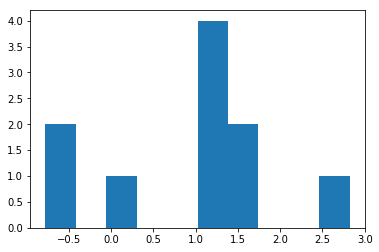

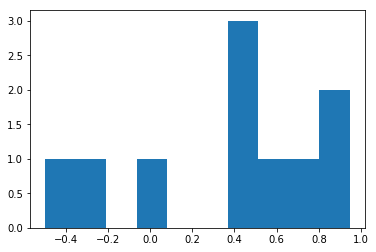

In [56]:
fig, ax = plt.subplots()
ax.hist(mean_difs)
fig, ax = plt.subplots()
ax.hist(mean_dif_difs)
# ax.semilogy(mean_difs, p_values, 'bo')